# 프로젝트 : 주식 예측에 도전해 보자

## 1. 데이터 준비
- **데이터 가져오기**
- **데이터 확인하기**

## 2. 데이터 전처리

## 3. 시계열 안정성 분석
- **정성적 그래프 분석**
- **안정성 확인하기**
- **계절성 상쇄하기**

## 4. 데이터 학습 및 테스트
- **적정 ARIMA 모수 찾기**
- **모델 학습하기**


- - -
### 데이터 준비

- **데이터 가져오기**

저는 국내 대기업 넥슨 주식을 가져오겠습니다.

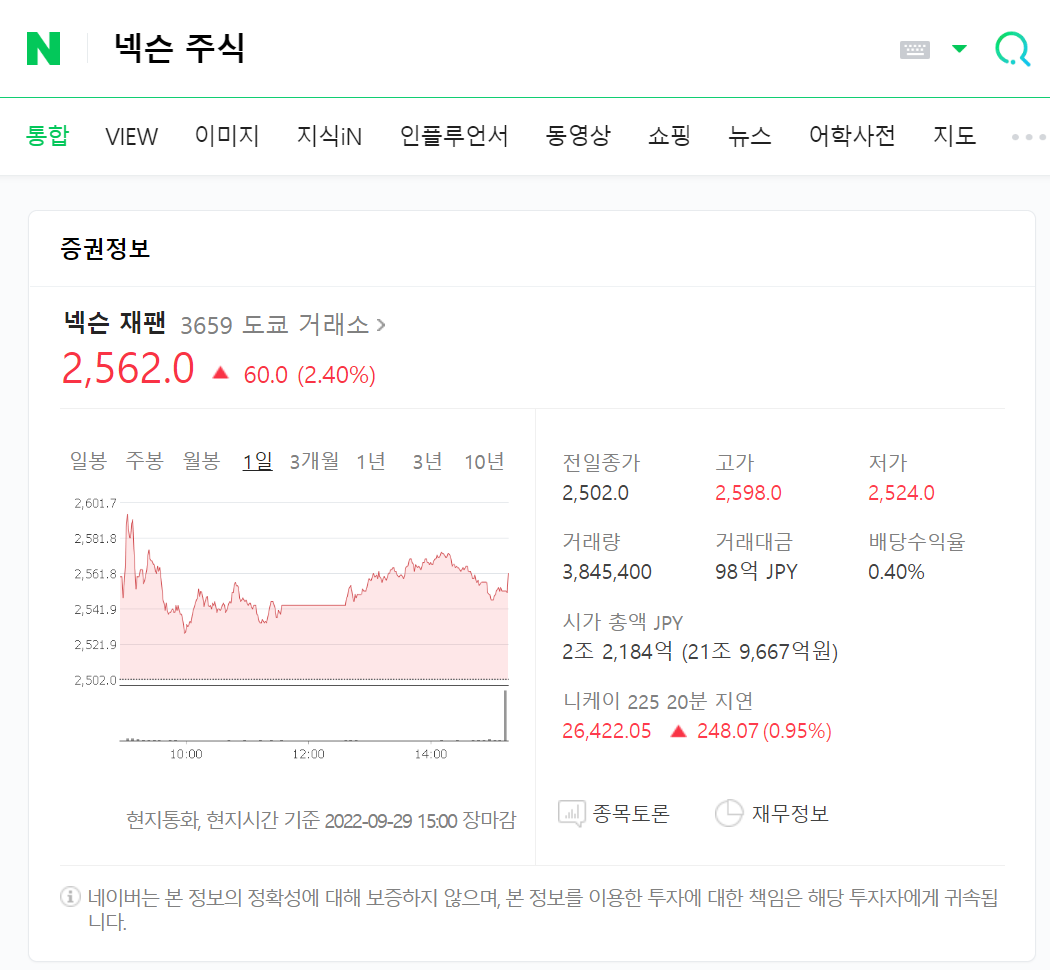

는 일본 회사였습니다.

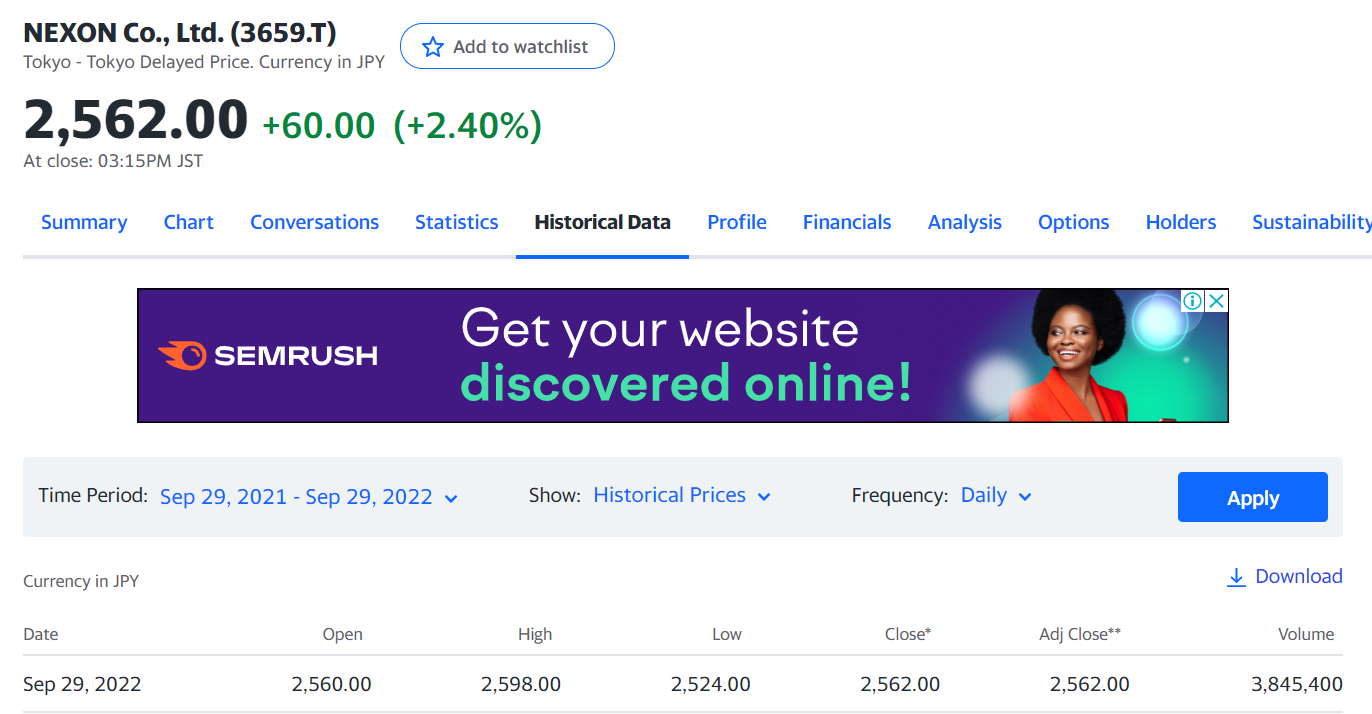

확인한 주식 정보를 가지고 [Yahoo Finance](https://finance.yahoo.com/)에서 데이터셋을 다운로드해줍니다.

- - -
### 데이터 준비

- **데이터 확인하기**

In [1]:
import pandas as pd

data = pd.read_csv('~/aiffel/EXPLORATION/dataset/3659.T.csv', index_col='Date')

data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-29,1850.0,1850.0,1780.0,1815.0,1807.832153,3378900
2021-09-30,1798.0,1837.0,1784.0,1807.0,1799.863770,3415600
2021-10-01,1804.0,1829.0,1753.0,1759.0,1752.053223,2051900
2021-10-04,1784.0,1784.0,1675.0,1680.0,1673.365234,2846800
2021-10-05,1687.0,1726.0,1676.0,1693.0,1686.313965,3193900


`Date`컬럼을 인덱스로 데이터 파일을 불러왔습니다.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, 2021-09-29 to 2022-09-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       246 non-null    float64
 1   High       246 non-null    float64
 2   Low        246 non-null    float64
 3   Close      246 non-null    float64
 4   Adj Close  246 non-null    float64
 5   Volume     246 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.5+ KB


총 246개의 데이터가 있으며

각 컬럼의 뜻은

**Open : 시가**  
**High : 고가**  
**Low : 저가**  
**Close : 종가**  
**Adj Close : 수정 종가**  
**Volume : 거래량**

입니다.

*2021-09-29* 부터 *2022-09-29* 까지의 데이터라는 것도 확인할 수 있습니다.

- - -
### 데이터 전처리

In [3]:
data = data[['Close']]

data.head()

,Close
Date,
2021-09-29,1815.0
2021-09-30,1807.0
2021-10-01,1759.0
2021-10-04,1680.0
2021-10-05,1693.0


인덱스 `Date`와 종가 `Close`컬럼을 제외한 나머지 정보는 필요 없으니 제거해줍니다.

In [4]:
data.index = pd.to_datetime(data.index) # data의 인덱스를 datetime 형식으로 변환합니다. (object → datetime)
data.isna().sum()

Close    0
dtype: int64

결측치는 없습니다.

- - -
### 시계열 안정성 분석

- **정성적 그래프 분석**

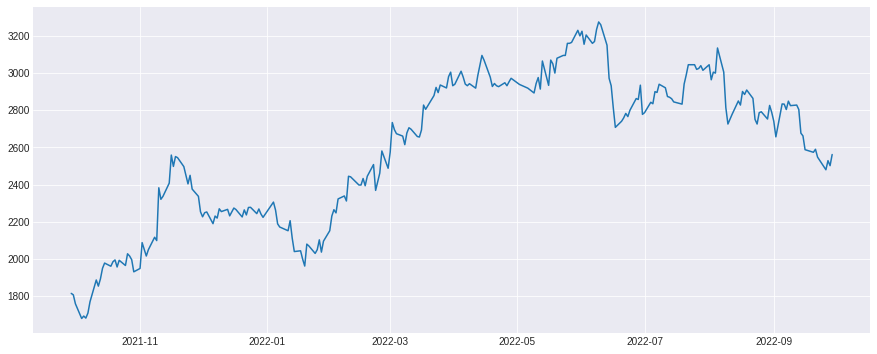

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.style.use('seaborn-darkgrid') # 그래프 스타일을 꾸며줍니다.
rcParams['figure.figsize'] = 15, 6 # 그래프 기본 사이즈 (15, 6)

plt.plot(data)
plt.show()

넥슨의 주가 변동을 그래프로 확인해봤습니다.

- 만일 그래프의 x축 눈금이 과하게 많이 생긴다면 데이터의 인덱스를 datetime 형식으로 변환해주세요.

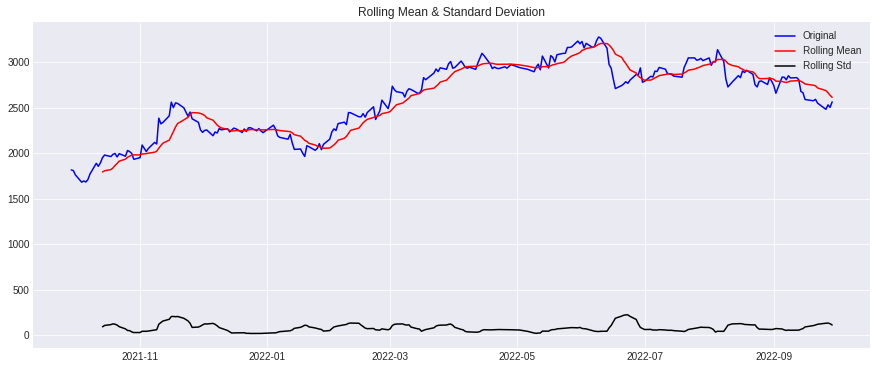

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_statistics(data, window=12)

그래프의 이동평균, 이동표준편차를 그래프로 보여주는 함수를 생성하고

`data`의 월 단위 이동평균과 이동표준편차를 시각화해봤습니다.

파란 선이 원본 시계열이고, 빨간 선이 이동평균, 검은 선이 이동표준편차를 보여줍니다.

- 이동평균 : 이전 데이터와 현재 데이터와의 평균값입니다. *ex) [10, 20, 30] = [15, 25]*
- 이동표준편차 : 이동평균에서 얼마나 이동했는지를 보여줍니다.

- - -
### 시계열 안정성 분석

- **안정성 확인하기**

In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

`statsmodels` 패키지에서 제공하는 `adfuller`를 이용해 **ADF 검정을 통한 유의확률**을 출력시키는 함수를 생성하고

`data`의 *p-value*를 확인해봤습니다.

- **유의확률(*p-value*)이란?**   
> 귀무가설이 맞다고 가정할 때 얻은 결과보다 극단적인 결과가 실제로 관측될 확률이다.  
> *p-value*가 작을수록 그 정도가 약하다고 보며, 대개 0.05나 0.01보다 작을 경우  
> 귀무가설을 기각하고 대립가설을 채택할 수 있는 근거가 된다.

In [8]:
augmented_dickey_fuller_test(data)

Results of Dickey-Fuller Test:
Test Statistic                  -2.012009
p-value                          0.281332
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


`data`의 *p-value*를 확인해본 결과 *0.281332*로 안정적인 시계열이라고 보기 힘듭니다.

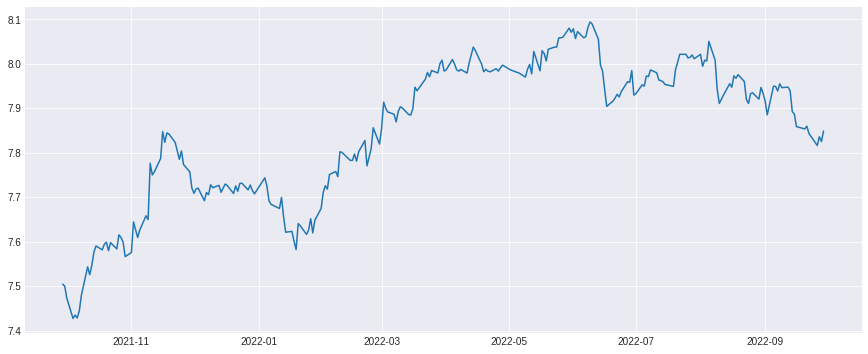

In [9]:
import numpy as np

data_log = np.log1p(data)

plt.plot(data_log)
plt.show()

로그변환한 `data`를 생성하고 그래프를 확인해봤습니다.

In [10]:
augmented_dickey_fuller_test(data_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.767200
p-value                          0.063114
#Lags Used                       3.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


*p-value*가 *0.063114*로 대립가설로 보는 기준에는 아직 부족합니다.

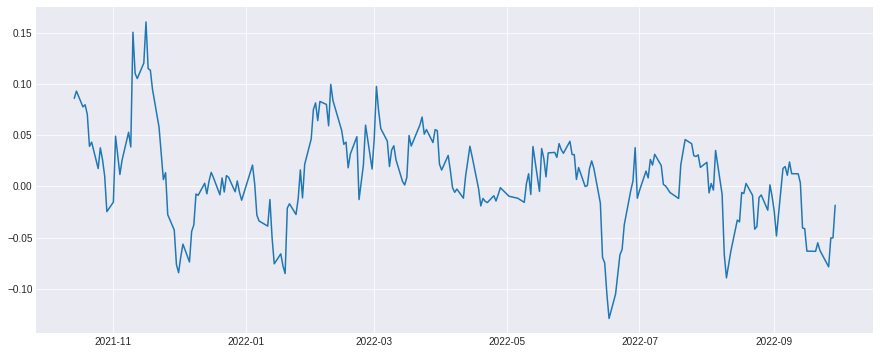

In [11]:
moving_avg = data_log.rolling(window=12).mean() # 이동평균
data_log_moving_avg = data_log - moving_avg # 변화량 제거
data_log_moving_avg.dropna(inplace=True)

plt.plot(data_log_moving_avg)
plt.show()

로그변환했던 데이터에서 이동평균만큼을 제거한 후 그래프를 확인해봤습니다.

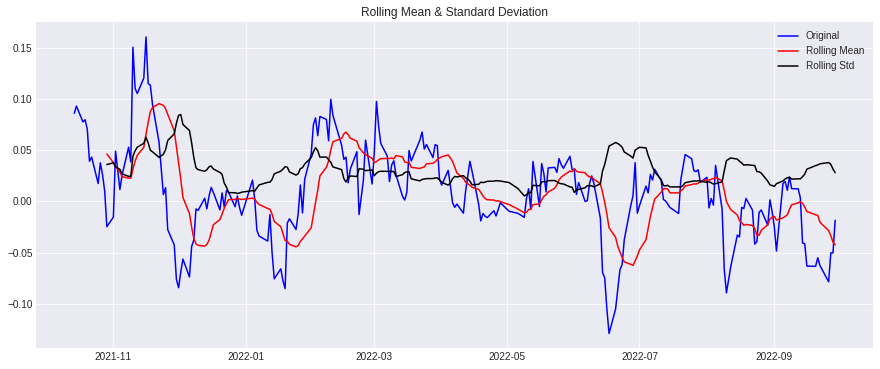

In [12]:
plot_rolling_statistics(data_log_moving_avg, window=12)

In [13]:
augmented_dickey_fuller_test(data_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.462107
p-value                          0.000230
#Lags Used                       3.000000
Number of Observations Used    231.000000
Critical Value (1%)             -3.458980
Critical Value (5%)             -2.874135
Critical Value (10%)            -2.573482
dtype: float64


이동평균만큼 변화량을 제거하니 *p-value*가 *0.000230*이 되면서 안정적인 시계열이라고 볼 수 있게 되었습니다.

- - -
### 시계열 안정성 분석

- **계절성 상쇄하기**

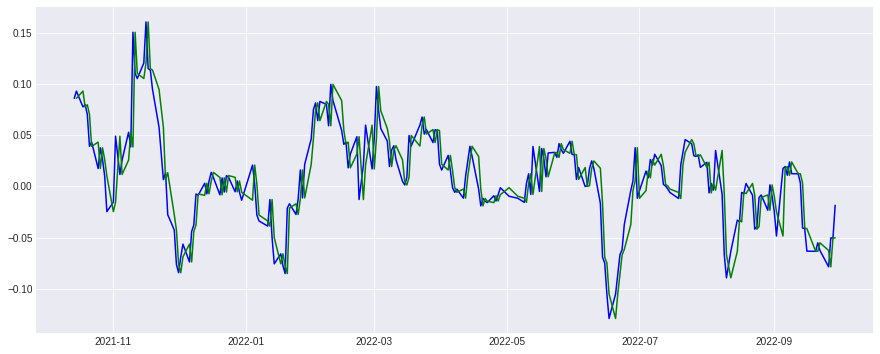

In [14]:
data_log_moving_avg_shift = data_log_moving_avg.shift()

plt.plot(data_log_moving_avg, color='blue')
plt.plot(data_log_moving_avg_shift, color='green')
plt.show()

원본 시계열과 소프트한 원본 시계열 그래프입니다.

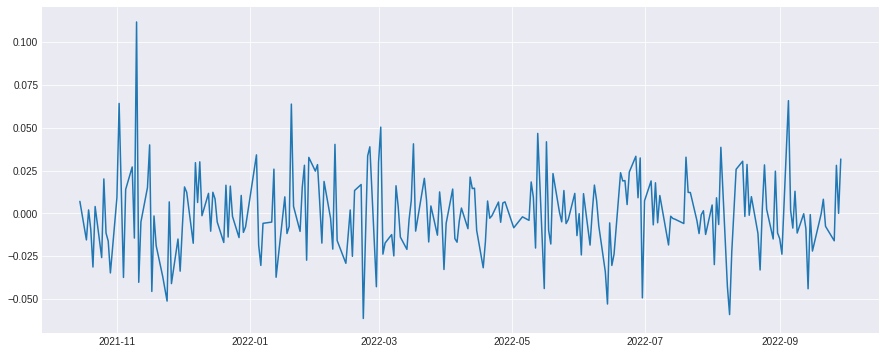

In [15]:
data_log_moving_avg_diff = data_log_moving_avg - data_log_moving_avg_shift
data_log_moving_avg_diff.dropna(inplace=True)
plt.plot(data_log_moving_avg_diff)
plt.show()

원본에서 소프트한 시계열을 빼고 그래프로 확인해봤습니다.

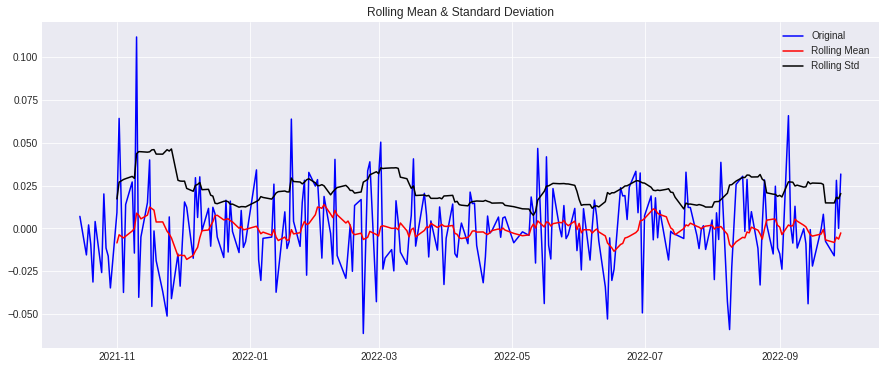

In [16]:
plot_rolling_statistics(data_log_moving_avg_diff)

다시 한 번 이동평균과 이동표준편차를 확인해봤습니다.

In [17]:
augmented_dickey_fuller_test(data_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.710905e+01
p-value                        7.387292e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


*p-value*가 굉장히 낮아져 지수화가 되었습니다.

위 과정들을 `statsmodels`에서는 모듈로 제공합니다.

`seasonal_decompose`메서드를 이용하면 시계열 데이터의 추세(`trend`)와 계절성(`seasonal`),

그리고 원본에서 추세와 계절성 변화를 제거한 `residual`까지 간편하게 확인할 수 있습니다.

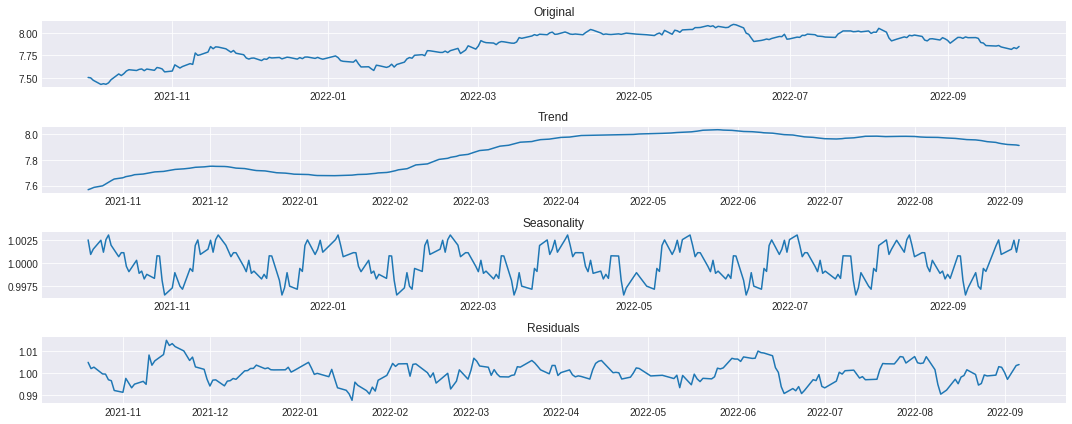

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log)
plt.title('Original')

plt.subplot(412)
plt.plot(trend)
plt.title('Trend')

plt.subplot(413)
plt.plot(seasonal)
plt.title('Seasonality')

plt.subplot(414)
plt.plot(residual)
plt.title('Residuals')

plt.tight_layout()

In [19]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.085923
p-value                          0.000015
#Lags Used                       4.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


`data`의 추세와 계절성 변화까지 제거한 `residual`는 대립가설로 보기에 충분히 낮은 *p-value*를 보여주고 있습니다.

- - -
### 데이터 학습 및 테스트

- **적정 ARIMA 모수 확인하기**

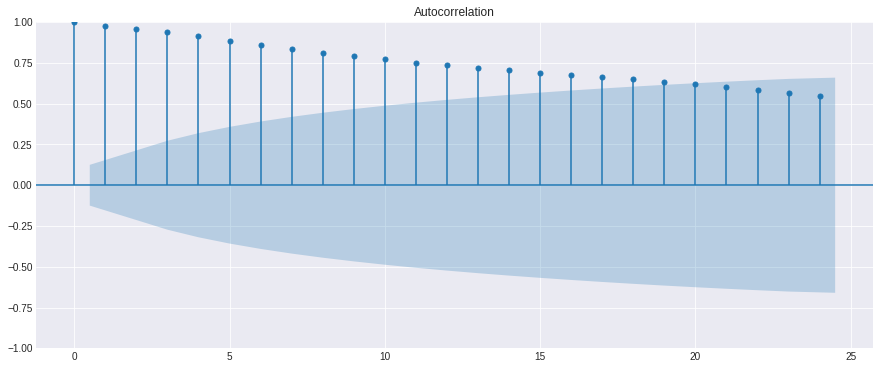

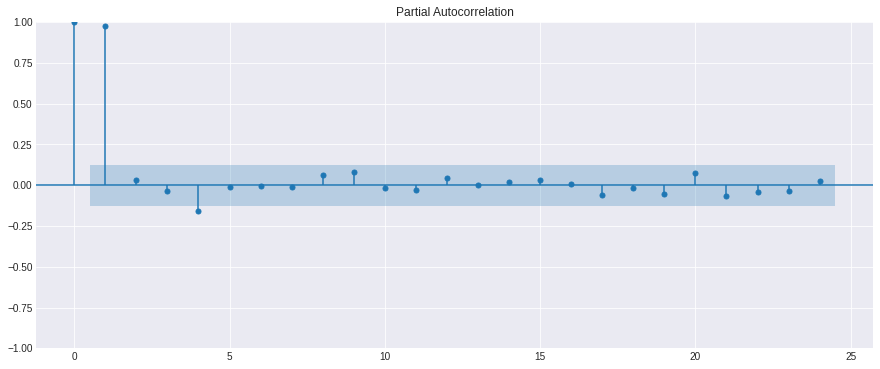

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(data_log, method='ywm')  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

`statsmodels`에서 제공하는 `ACF`와 `PACF` 플로팅 기능을 사용해 그래프를 확인해봤습니다.

`ACF`가 19번 째 lag에서 마지막으로 유의미하다고 보여주고 있고,
`PACF`는 4번 째 lag에서 마지막으로 유의미하다고 보여주고 있습니다.

이를 ARIMA에 적용한다면 AR은 4, I는 0, MA는 19로 적용하면 되겠습니다.

- - -
### 데이터 학습 및 테스트

- **모델 학습하기**

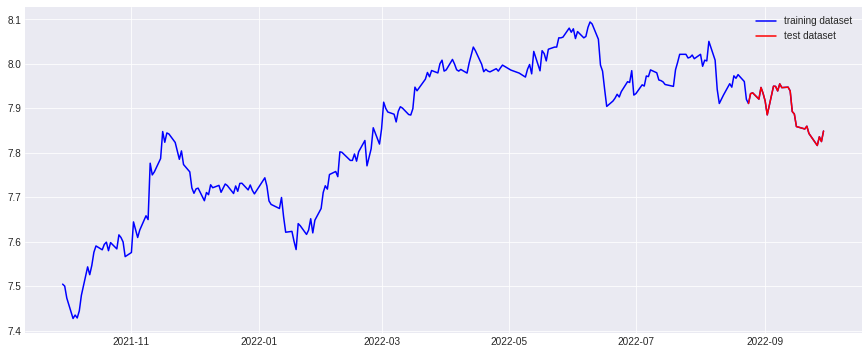

In [21]:
train_data, test_data = data_log[:int(len(data_log)*0.9)], data_log[int(len(data_log)*0.9):]

plt.plot(data_log, c='b', label='training dataset')
plt.plot(test_data, c='r', label='test dataset')
plt.legend()
plt.show()

모델을 학습하기 위해 9:1로 나눠서 학습용 데이터와 테스트용 데이터로 분리해줍니다.

그래프의 파란 선이 학습할 내용이고 빨간 선이 예측해야 하는 내용입니다.

In [22]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(4, 0, 19))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                ARIMA(4, 0, 19)   Log Likelihood                 507.301
Date:                Thu, 29 Sep 2022   AIC                           -964.601
Time:                        13:27:48   BIC                           -879.647
Sample:                             0   HQIC                          -930.298
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8085      0.074    105.374      0.000       7.663       7.954
ar.L1          1.2648      9.950      0.127      0.899     -18.236      20.766
ar.L2         -0.2024     15.417     -0.013      0.9

...봐도 뭔지는 아직 잘 이해하지 못했습니다.

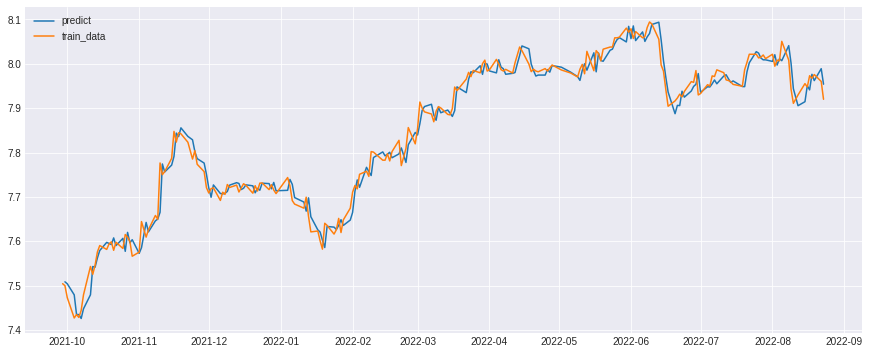

In [23]:
model = ARIMA(train_data, order=(4, 0, 19))
fitted_m = model.fit()
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()
plt.show()

`ARIMA` 모델을 이용해 `train` 데이터에 대해 예측을 한 결과입니다.

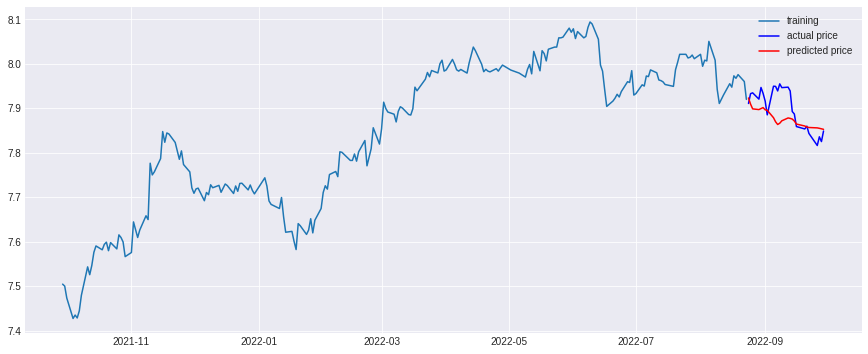

In [24]:
model = ARIMA(train_data, order=(4, 0, 19))
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

사실상 미래라고 볼 수도 있는 `test` 데이터에 대해 예측을 한 모습입니다.

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = mean_absolute_percentage_error(np.exp(test_data), np.exp(fc))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  14448.209217736256
MAE:  94.73896066165281
RMSE:  120.20070389867215
MAPE: 3.42%


RMSE는 120, 오차율은 3.42%로 그래프 상으로도 그렇고 예측이 어느 정도 맞는 것 같습니다.

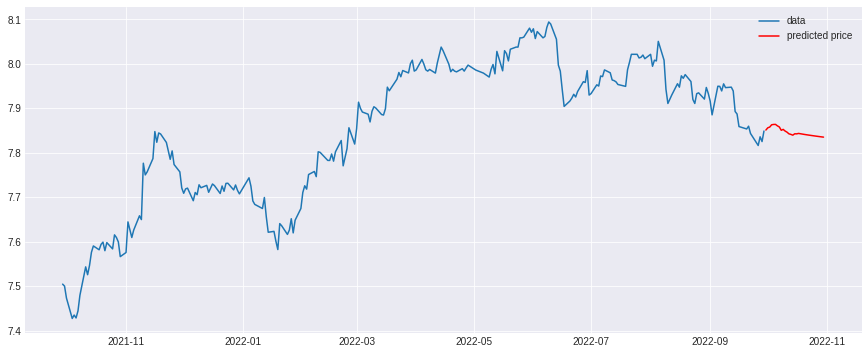

In [26]:
model = ARIMA(data_log, order=(4, 0, 19))
fitted_m = model.fit()
fc = fitted_m.forecast(31, alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=pd.date_range('2022-09-30', '2022-10-30'))

plt.plot(data_log, label='data')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

내친김에 실제 미래에 대해서도 예측을 진행해봤습니다.

순전히 재미로만 봐주시길 바랍니다.

- - -
## 마무리하며

시작부터 예상 못한 난관이 있었습니다.

주식이란 것에 대해 모르는 게 많다보니 주식 종류는 어떻게 고르고 데이터는 어디서 받는지를 방승욱 팀원님의 도움을 받아 해결했습니다.

그리고 며칠 전까지 데이터톤을 하다가 우연찮게 생긴 버그가 발생한 적이 있는데

matplotlib 그래프 스타일이 멋대로 변경되는 버그였습니다.

커널을 재시작하니 버그가 사라지긴 했지만 그래프 배경을 꾸밀 수 있는 소스가 있을거란 생각에

프로젝트를 작성하다가 딴 길로 새버려(?) matplotlib api를 좀 공부하다가 왔습니다.

모듈은 원래 맨 처음 셀에 모두 모아서 작성했는데 그러다보면 주로 통째로 복사 붙여넣기를 사용하게 되고

자꾸만 복붙 기능을 이용하다보면 언젠가 모듈을 불러와놓고 무슨 모듈인지도 모르게 될까봐 이번에는 필요한 셀에서 꼬박꼬박 불러와서 사용했습니다.

제일 힘들었던 점은 시계열 데이터를 이해하는 부분과 ARIMA 모델의 최적의 모수를 찾는 것이였습니다.

tsaplots 그래프는 ACF(MA), PACF(AR) 순서로 그려놓고 ARIMA는 왜 헷갈리게끔 AR이 먼저 시작하는지

결론은 '안정적이다' 또는 '안정적이지 않다' 이면서 왜 굳이 귀무가설 대립가설이라는 어려운 단어로 표현을 했는지

성격이 다른 차분 파라미터는 왜 AR과 MA 사이에 들어가게 된건지

노드 진행상 p값을 14로 넣고 그 이유에 대해선 그래프를 참고하라는 설명만 남은 것은 무슨 이유에서인지

LMS의 내용으로도 충분히 이해가 되지 않아 추가로 정보를 찾아보고 이해할 것 같아서 적용해보면 왜 자꾸 정반대의 결과가 나오는건지

때문에 필요한 내용에 대해서는 이해를 한 것 같으나 이게 정말 맞게 이해를 한 것인지 대해서는 의문이 생기고

제가 LMS에서 나온 코드에만 너무 의존하는 것도 문제이긴 한데 LMS에서 보여준 예시 코드를 그대로 적용해보니 오류가 생기는 일도 더러 있고 해서 이번 익스플로레이션은 다소 불친절하지 않았나 하는 감이 있습니다.